In [ ]:
%pip install pandas

In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, pipeline, tree
from sklearn.metrics import f1_score, roc_auc_score,classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix,precision_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Load the dataset, handling quoting issues and errors
df = pd.read_csv('/content/sample_data/fake_job_postings.csv',
                 encoding='ISO-8859-1')  # Print a warning for bad lines
                 # or on_bad_lines='skip' to skip bad lines

# Basic info
print(df.shape)  # Rows and columns

(17880, 18)


In [ ]:
# Getting an overview of the features and their types in the dataset
print("Overview of the features and their types:")
df.info()

Overview of the features and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry   

In [ ]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI â Environmental Systems Re...,"EDUCATION:Â Bachelorâs or Masterâs in GIS,...",Our culture is anything but corporateâwe hav...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# Removing any leading, and trailing whitespaces in columns
df.columns = df.columns.str.strip()

In [ ]:
# Count the number of columns with dtype 'object'
object_cols = df.select_dtypes(include=['object']).columns
num_object_cols = len(object_cols)

# Count the number of columns with dtype 'int64'
int_cols = df.select_dtypes(include=['int64']).columns
num_int_cols = len(int_cols)

print(f"Number of columns with object dtype: {num_object_cols}")
print(f"Number of columns with int64 dtype: {num_int_cols}")

Number of columns with object dtype: 13
Number of columns with int64 dtype: 5


In [ ]:
# Check for missing values
print('Null Values in Each Column:\n')
print(df.isnull().sum())

Null Values in Each Column:

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [ ]:
# View percentage of missing values per column
print('Percent of Null Values in Each Column:\n')
print(df.isnull().mean() * 100)

Percent of Null Values in Each Column:

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


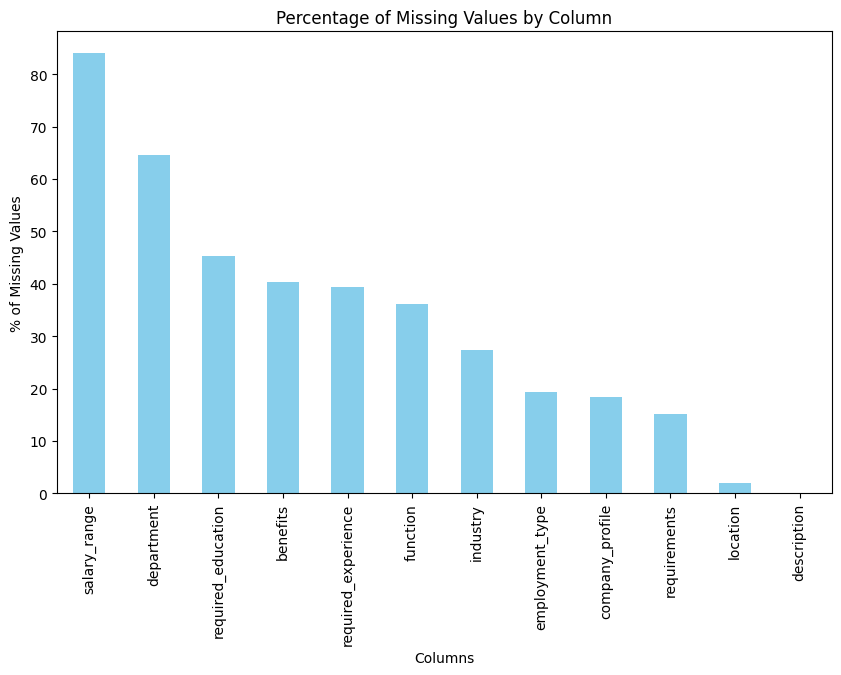

In [ ]:
# Count and display percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% of Missing Values')
plt.xlabel('Columns')
plt.show()

In [ ]:
# For text columns, replace missing values with Missing
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [ ]:
# For other categorical columns, replace missing values with relevant placeholders
df.fillna({'location': 'Unknowm'}, inplace=True)
df.fillna({'department': 'Unknowm'}, inplace=True)
df.fillna({'salary_range': 'Not Specified'}, inplace=True)
df.fillna({'employment_type': 'Not Specified'}, inplace=True)
df.fillna({'required_experience': 'Not Specified'}, inplace=True)
df.fillna({'required_education': 'Not Specified'}, inplace=True)
df.fillna({'industry': 'Not Specified'}, inplace=True)
df.fillna({'function': 'Not Specified'}, inplace=True)

In [ ]:
print("Fraudulent Value Counts:")
print(df['fraudulent'].value_counts())

Fraudulent Value Counts:
fraudulent
0    17014
1      866
Name: count, dtype: int64


In [ ]:
# Calculate the total number of job postings
total_postings = len(df)

# Calculate the number of fraudulent postings
fraudulent_postings = df['fraudulent'].value_counts().get(1, 0)

# Calculate the percentage of fraudulent postings
fraud_percentage = (fraudulent_postings / total_postings) * 100

print(f'Total Job Postings: {total_postings}')
print(f'Number of Fraudulent Postings: {fraudulent_postings}')
print(f'Percentage of Fraudulent Postings: {fraud_percentage:.2f}%')

Total Job Postings: 17880
Number of Fraudulent Postings: 866
Percentage of Fraudulent Postings: 4.84%


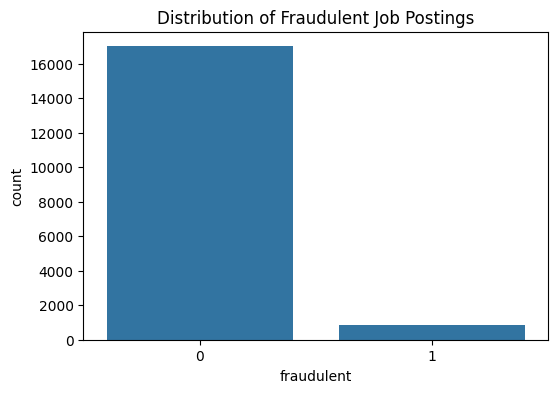

In [ ]:
# Bar plot for fraudulent (target) feature
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent Job Postings')
plt.show()

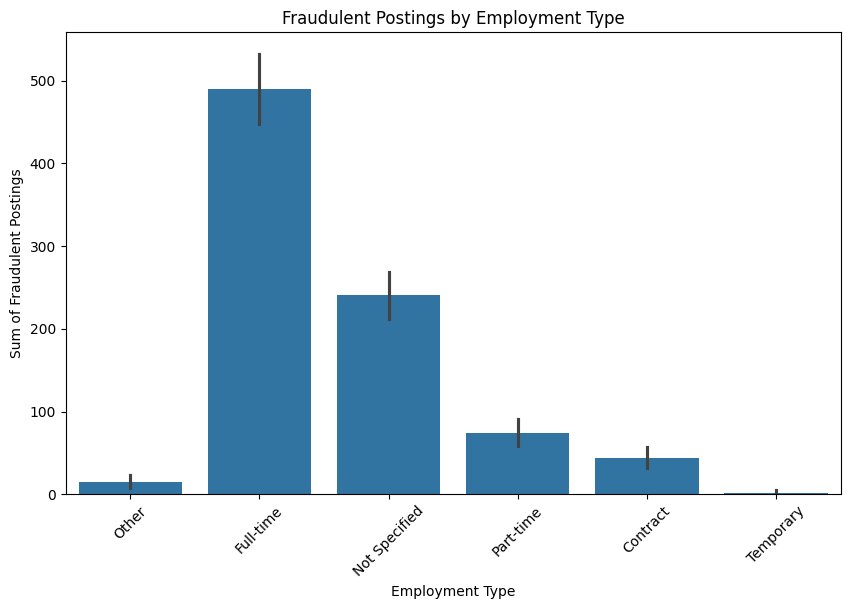

In [ ]:
# Bar plot for employment_type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

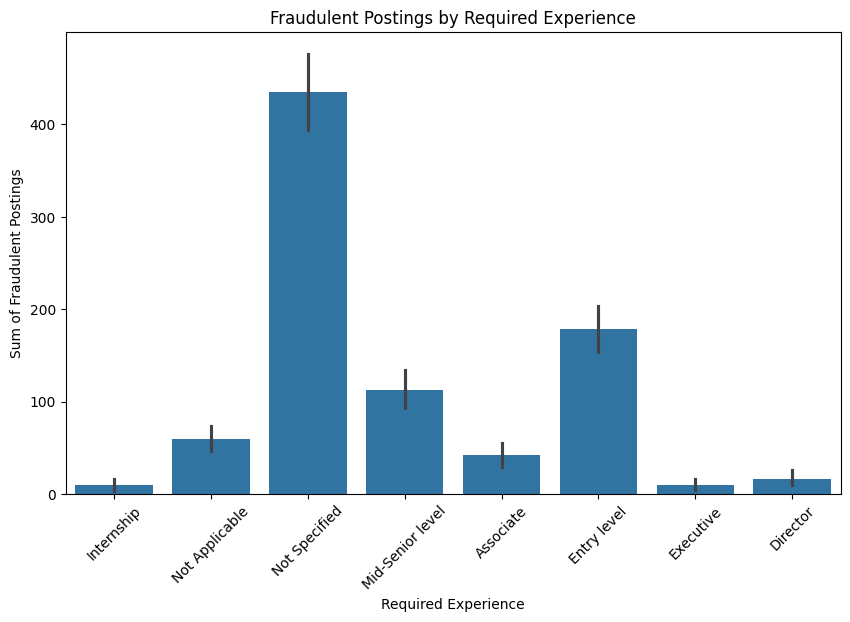

In [ ]:
# Bar plot for required_experience
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df = pd.read_csv('/content/fake_job_postings.csv',
                 encoding='ISO-8859-1')

In [ ]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.shape

(17880, 18)

In [ ]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
df = df[['title', 'location','company_profile', 'requirements', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function','salary_range',
       'fraudulent']]

In [ ]:
# Check if there is any null value
df.isna().apply(pd.value_counts)

<ipython-input-33-bd7758a0550b>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df.isna().apply(pd.value_counts)


,title,location,company_profile,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_range,fraudulent
False,17880.0,17534,14572,15184,17880.0,17880.0,17880.0,14409,10830,9775,12977,11425,2868,17880.0
True,NaN,346,3308,2696,NaN,NaN,NaN,3471,7050,8105,4903,6455,15012,NaN


In [ ]:
#Check for number of null values
df.isnull().sum()

,0
title,0
location,346
company_profile,3308
requirements,2696
telecommuting,0
has_company_logo,0
has_questions,0
employment_type,3471
required_experience,7050
required_education,8105


In [ ]:
#Check if any duplicate rows in dataset
df.duplicated().sum()

493

In [ ]:
#drop the duplicate values
df.drop_duplicates(inplace=True)

In [ ]:
#Differentiate categorical data and numerical data
df_num = df[['telecommuting','has_company_logo','has_questions','fraudulent','salary_range']]
df_cat = df[['title', 'location','company_profile', 'requirements','employment_type',
       'required_experience', 'required_education', 'industry', 'function']]

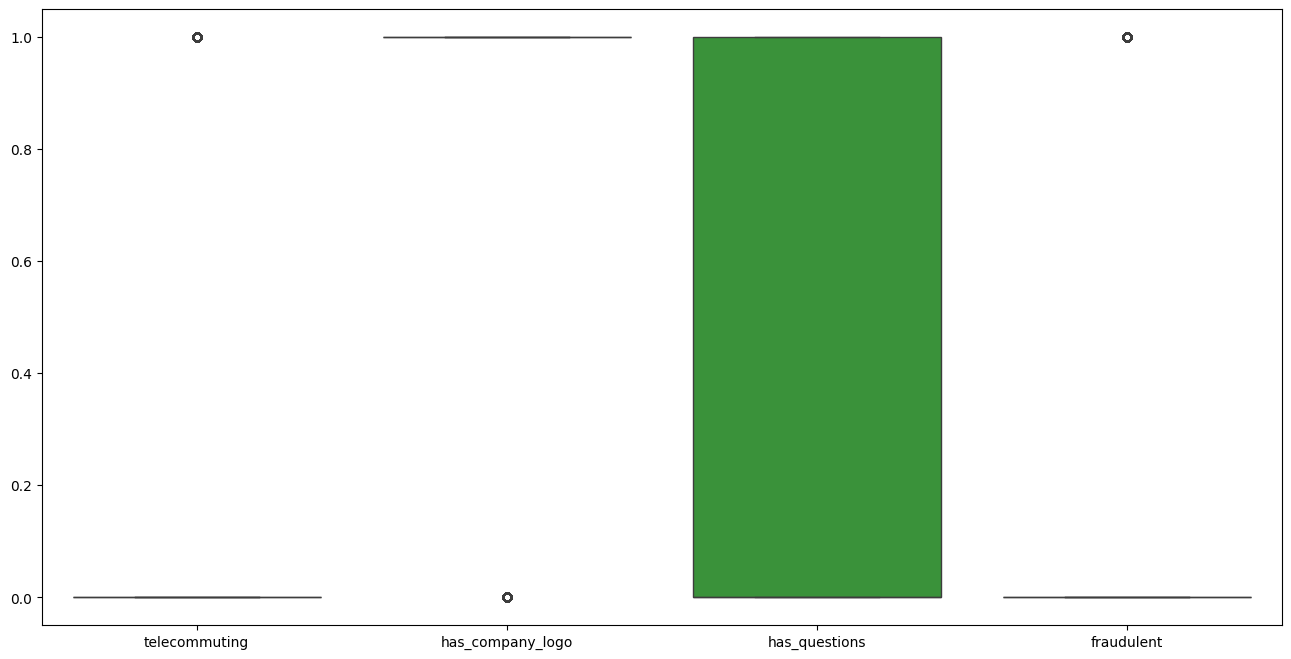

In [ ]:
# Checking for Outliers in numerical data
plt.figure(figsize=[16,8])
sns.boxplot(data = df_num)
plt.show()

In [ ]:
#Removing Outliers from columns
df_num = df_num[df_num['telecommuting'] < 0.9 ]
df_num = df_num[df_num['fraudulent'] < 0.9 ]
df_num = df_num[df_num['has_company_logo'] > 0.1 ]
df_num

,telecommuting,has_company_logo,has_questions,fraudulent,salary_range
0,0,1,0,0,NaN
1,0,1,0,0,NaN
2,0,1,0,0,NaN
3,0,1,0,0,NaN
4,0,1,1,0,NaN
...,...,...,...,...,...
17872,0,1,0,0,NaN
17873,0,1,0,0,NaN
17875,0,1,1,0,NaN
17876,0,1,1,0,NaN


In [ ]:
df.shape

(17387, 14)

In [ ]:
df.isnull().sum()

,0
title,0
location,340
company_profile,3255
requirements,2550
telecommuting,0
has_company_logo,0
has_questions,0
employment_type,3397
required_experience,6858
required_education,7889


In [ ]:
df.dropna(axis= 0, how= 'any', inplace=True)

In [ ]:
df.isnull().sum()

,0
title,0
location,340
company_profile,3255
requirements,2550
telecommuting,0
has_company_logo,0
has_questions,0
employment_type,3397
required_experience,6858
required_education,7889


In [ ]:
'''
after outliers and missing values has been removed.
'''
df.shape

(1485, 14)

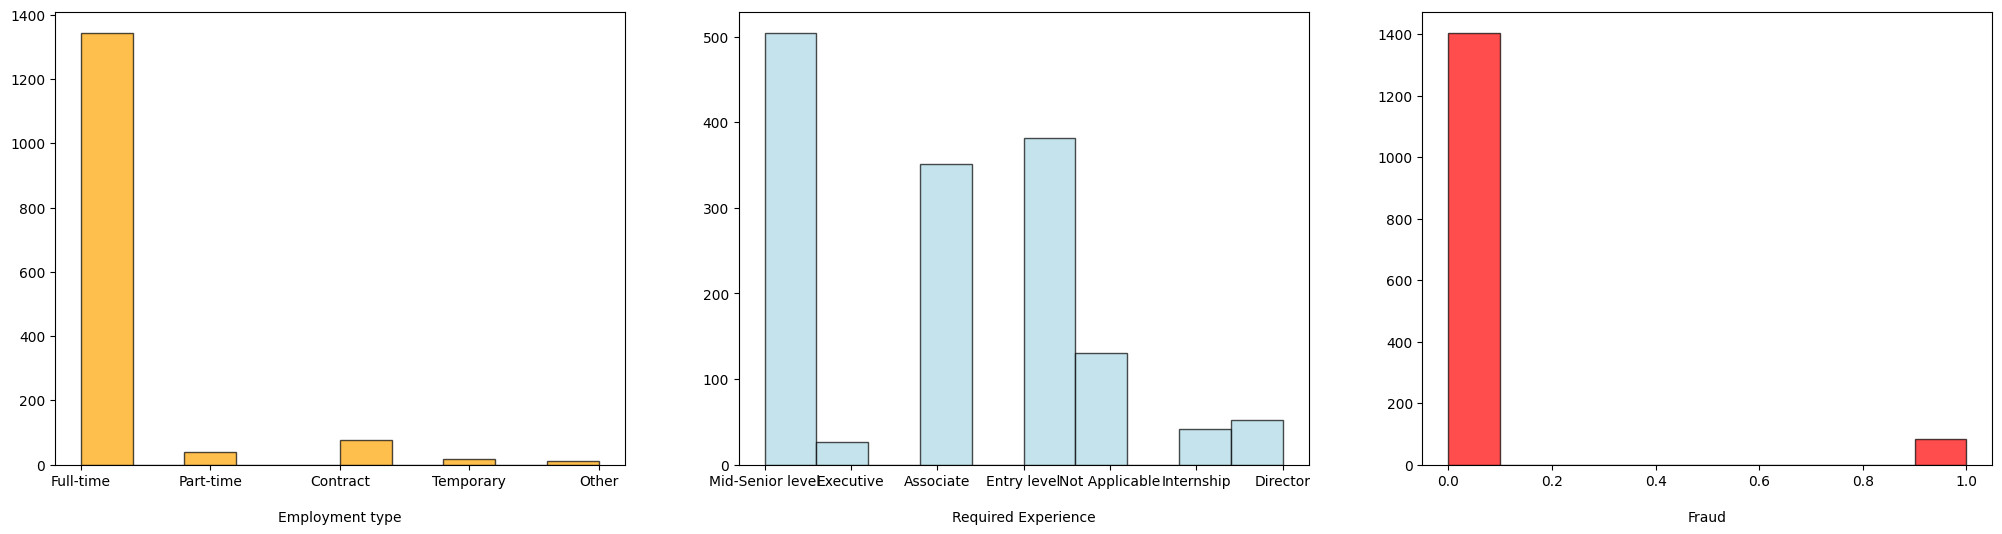

'\nFull-time jobs are posted more comparatively to other type of employment.\nThere are more jobs available that requires Mid-senior level Experience.\n'

In [ ]:
# Plots to see the distribution of the continuous features individually

plt.figure(figsize= (25,20))
plt.subplot(3,3,1)
plt.hist(df.employment_type, color='orange', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')

plt.subplot(3,3,2)
plt.hist(df.required_experience, color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')

plt.subplot(3,3,3)
plt.hist(df.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')


plt.show()

'''
Full-time jobs are posted more comparatively to other type of employment.
There are more jobs available that requires Mid-senior level Experience.
'''

<ipython-input-46-67d99f618c9e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='function',data=df,palette='Set1')


'\nThere are maximum number of jobs are posted in IT field and minimum jobs are posted related to Distribution.\nJobs in Sales,IT,Marketing,Engineering,Customer Service,Administrative are most in demand jobs.\n'

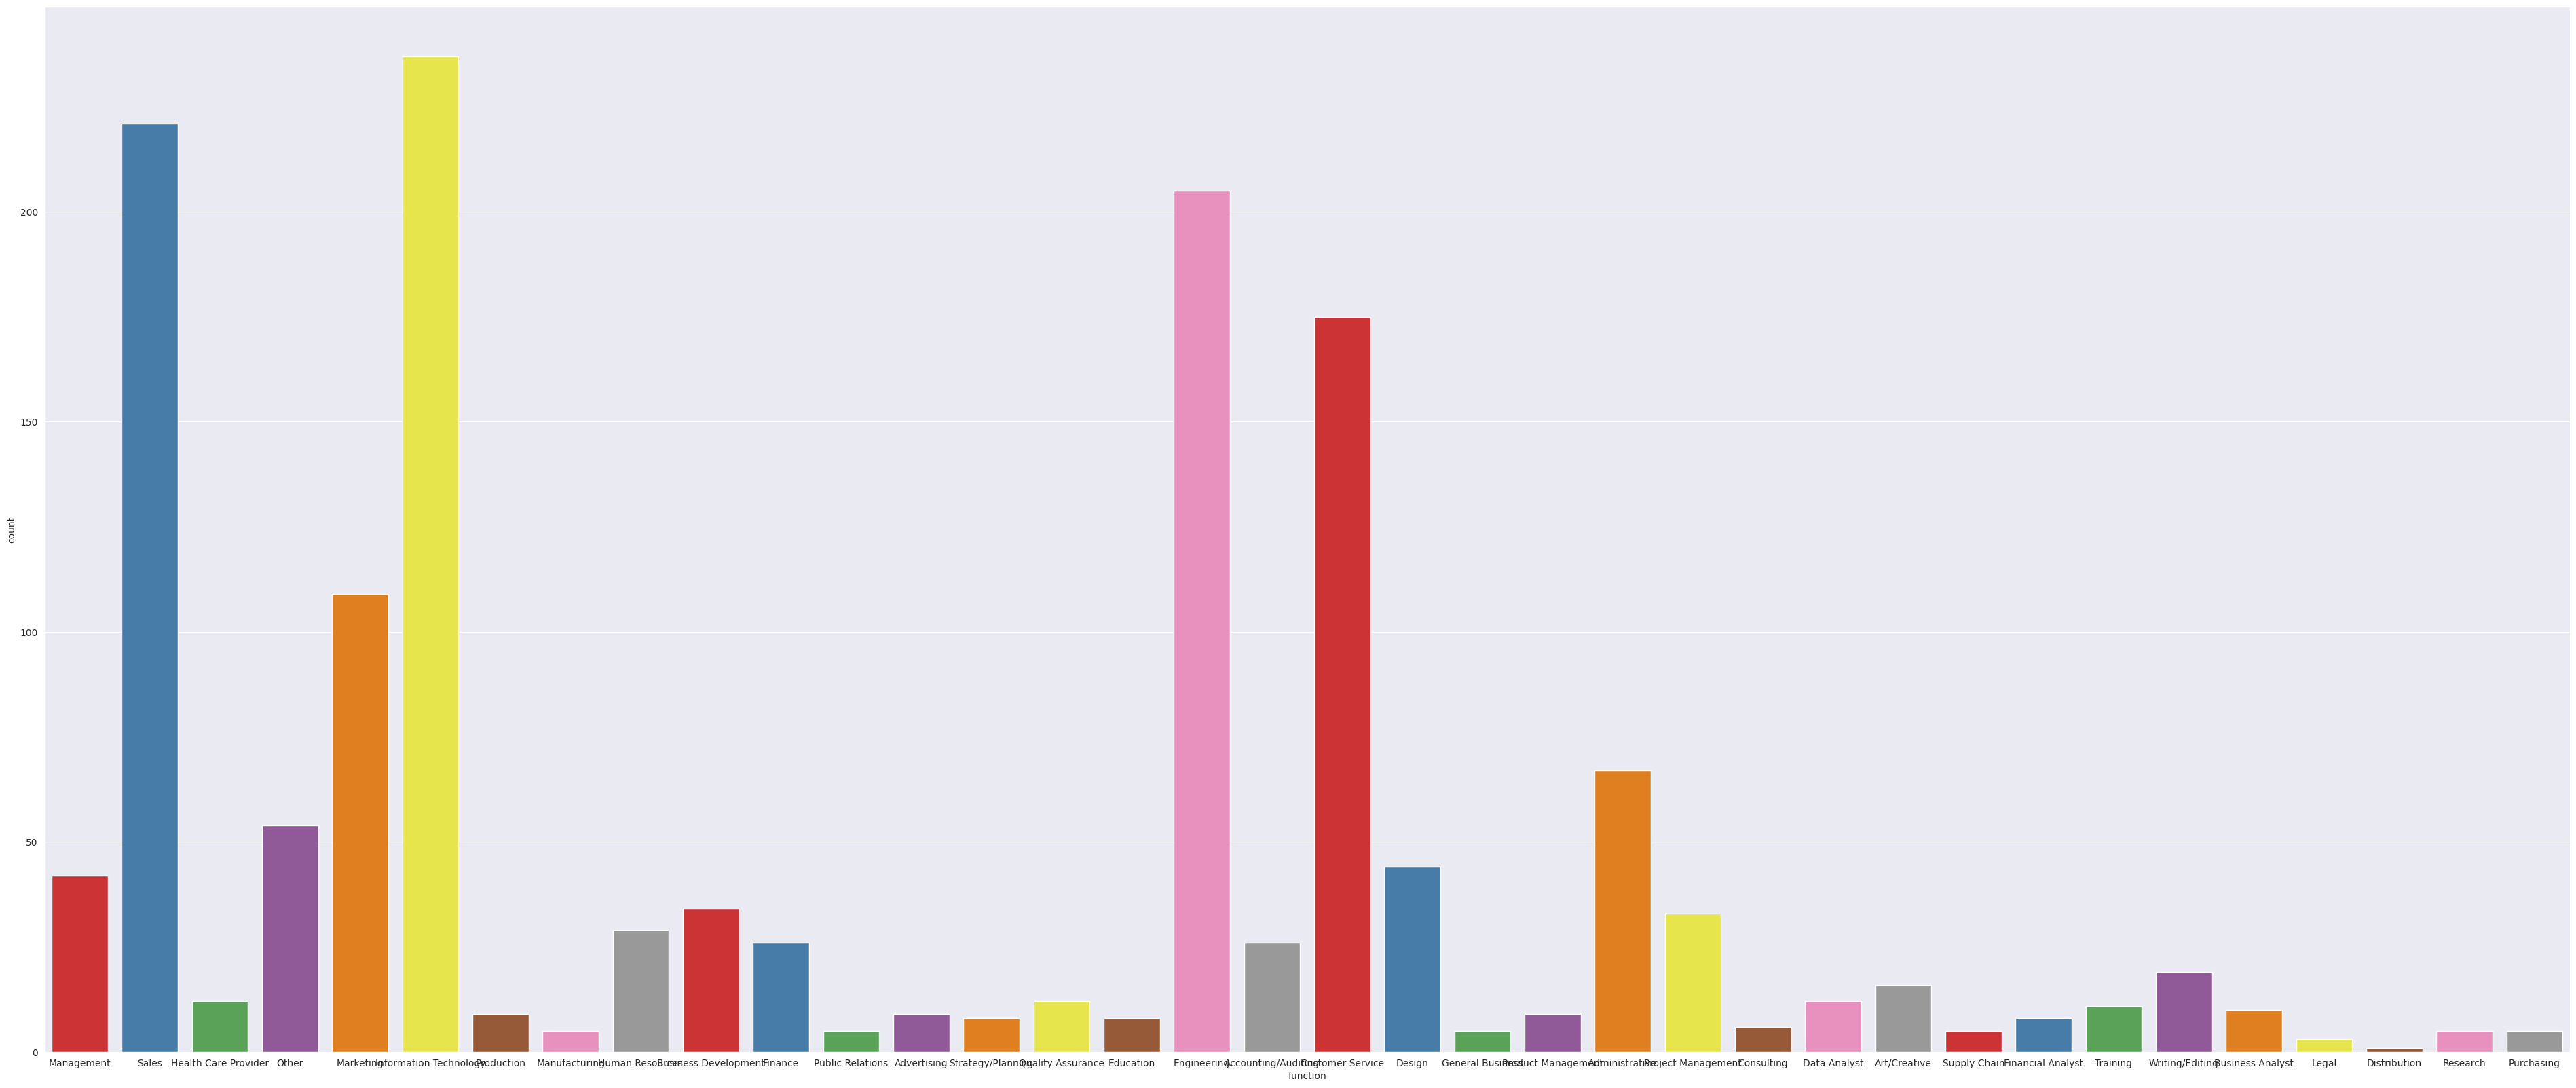

In [ ]:
plt.figure(figsize=(48,20))
sns.set_style("darkgrid")
sns.countplot(x='function',data=df,palette='Set1')

'''
There are maximum number of jobs are posted in IT field and minimum jobs are posted related to Distribution.
Jobs in Sales,IT,Marketing,Engineering,Customer Service,Administrative are most in demand jobs.
'''

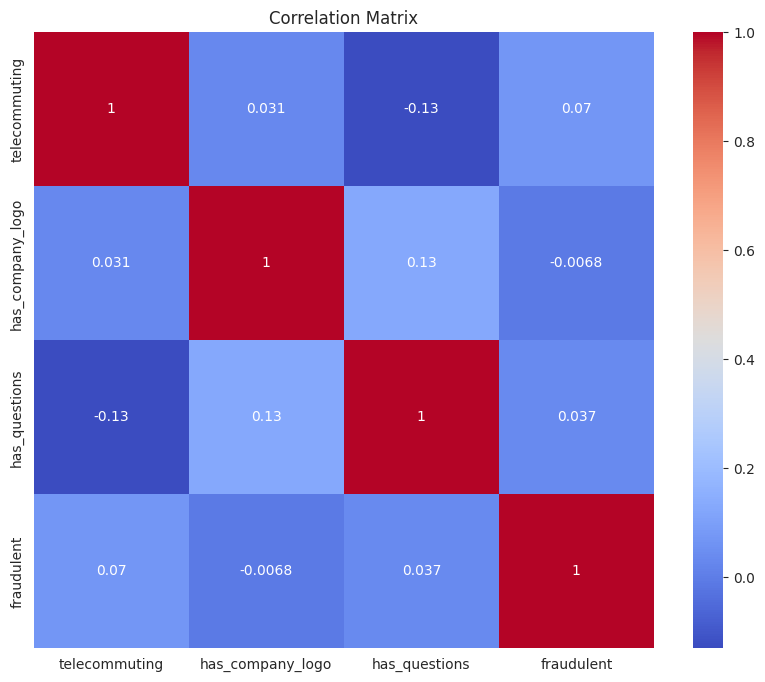

In [ ]:
# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=['number']).columns

# Calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plotting the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Data Loading
df = pd.read_csv('/content/sample_data/fake_job_postings.csv',encoding='ISO-8859-1')

In [ ]:
# Dropping Irrelevant Numerical Columns: Removes columns like telecommuting and has_questions
numerical_to_drop=['telecommuting','has_questions']

df.drop(columns=numerical_to_drop, inplace=True)

In [ ]:
# Filtering by has_company_logo: Keeps rows where has_company_logo > 0, indicating jobs with logos.
df=df[df['has_company_logo']>0.0]

In [ ]:
# Extracts the country from the location column.
df['country'] = df['location'].str.split(',').str[0]

<ipython-input-16-a0d85c32929a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country'] = df['location'].str.split(',').str[0]


In [ ]:
df.nunique()

,0
job_id,14220
title,9091
location,2393
department,1078
salary_range,659
company_profile,1628
description,11727
requirements,9802
benefits,5085
has_company_logo,1


In [ ]:
# Balances the dataset by oversampling the minority class (fraudulent=1) to match the size of the majority class.
fake=df[df['fraudulent']==1]
fake.shape

(283, 17)

In [ ]:
real=df[df['fraudulent']==0]
real.shape

(13937, 17)

In [ ]:
df.shape

(14220, 17)

In [ ]:
fake=fake.sample(13937,replace=True)

In [ ]:
real.shape,fake.shape

((13937, 17), (13937, 17))

In [ ]:
df = pd.concat([fake, real], ignore_index=True)
df.reset_index()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,has_company_logo,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,0,5752,"Account Sales Managers $80-$130,000/yr","US, NY, Buffalo",NaN,NaN,We have aggressive growth plans in place for t...,We provide No Credit Check Financing to custom...,Experience and Skills ï¿½ï¿½Required- Minimum ...,We Provide- Complete online training and offic...,1,Full-time,Associate,High School or equivalent,Financial Services,Business Development,1,US
1,1,4579,Service Associate,"US, TX, Arlington",Financial Dept,28000-35000,The Accionï¿½ï¿½ story began more than 100 yea...,"ýý ýý ýý ýýWelcome and greet customers, modeli...",ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ýý ý...,"401K, HEALTH CARE PLAN , DENTAL , LIFE INSURAN...",1,Full-time,Entry level,High School or equivalent,Financial Services,NaN,1,US
2,2,7371,Front-End Developer,"US, IN, Bloomington",Product Development,NaN,NaN,RideAmigos needs a great Front-End Developer t...,This opening is for a qualified developer focu...,"This is a full time, salaried position. Let us...",1,NaN,NaN,NaN,NaN,NaN,1,US
3,3,5299,Customer Assistant,"CA, AB, Calgary",NaN,NaN,Inctor Consulting is world wide known for advi...,Duties:- Perform clerical tasks related to the...,Skills/Qualifications:- Attention to Detail.- ...,Apply:To apply please send your Resume: #EMAIL...,1,NaN,NaN,NaN,NaN,NaN,1,CA
4,4,17644,Daily Money Team Representative,"US, ,",Work at home,NaN,Daily Money Teamï¿½ï¿½is the industry leader f...,Looking for customer service reps who want to ...,Must be articulate and able to communicate ove...,$20-100 per referral. Make up to $100/day,1,Part-time,NaN,High School or equivalent,Telecommunications,Accounting/Auditing,1,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27869,27869,17873,Product Manager,"US, CA, San Francisco",Product Development,NaN,Flite delivers ad innovation at scale to the w...,Flite's SaaS display ad platform fuels the wor...,BA/BS in Computer Science or a related technic...,Competitive baseAttractive stock option planMe...,1,Full-time,NaN,NaN,Internet,Product Management,0,US
27870,27870,17874,Recruiting Coordinator,"US, NC, Charlotte",NaN,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,1,Contract,NaN,NaN,Utilities,NaN,0,US
27871,27871,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time youï¿½ï¿½ï...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,CA
27872,27872,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting-ï¿½ï¿½Desire to h...,Health &amp; WellnessMedical planPrescription ...,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US


<ipython-input-24-d1ff3d41137a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='fraudulent',palette='rainbow')


<Axes: xlabel='fraudulent', ylabel='count'>

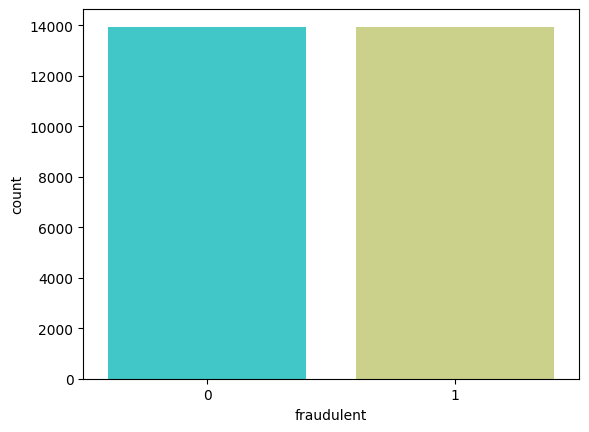

In [ ]:
sns.countplot(data=df,x='fraudulent',palette='rainbow')

<ipython-input-25-99d186893f5d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=df, x='country', order=country, palette='rainbow')


Text(0, 0.5, 'No. of Jobs')

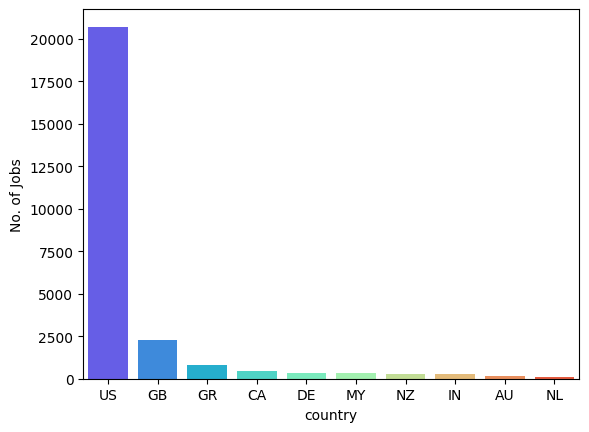

In [ ]:
country = df['country'].value_counts().nlargest(10).index.tolist()
ax=sns.countplot(data=df, x='country', order=country, palette='rainbow')
ax.set_ylabel('No. of Jobs')

<ipython-input-26-a2717cbc75a3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=df, x='employment_type', palette='rainbow')


Text(0, 0.5, 'No. of Jobs')

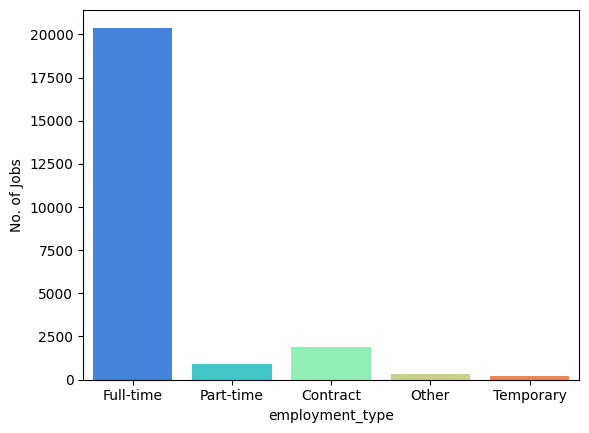

In [ ]:
ax=sns.countplot(data=df, x='employment_type', palette='rainbow')
ax.set_ylabel('No. of Jobs')

<ipython-input-27-1115eaf880f9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='required_experience', palette='rainbow')


Text(0, 0.5, 'No. of Jobs')

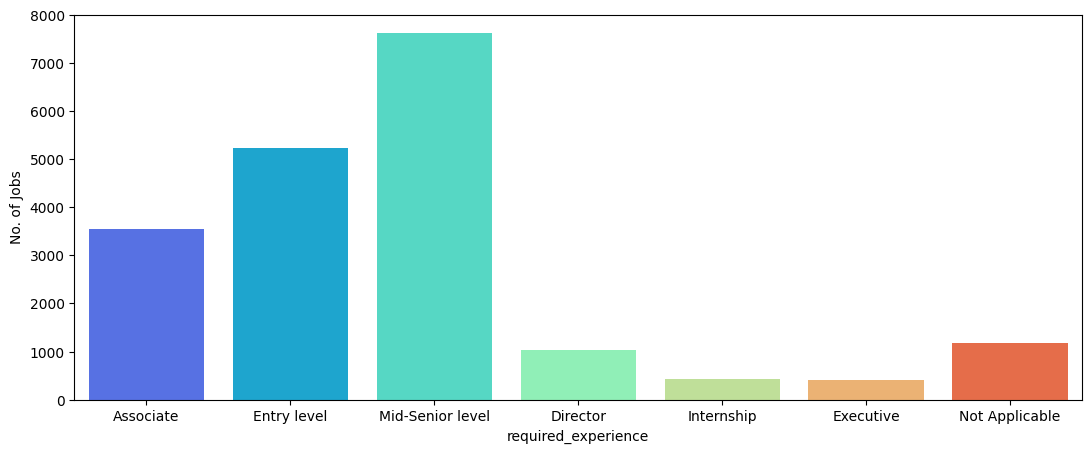

In [ ]:
plt.figure(figsize=(13,5))
ax = sns.countplot(data=df, x='required_experience', palette='rainbow')
ax.set_ylabel('No. of Jobs')

<ipython-input-28-e1dcd49fd9d7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=df, x='required_education', order=country, palette='rainbow')


Text(0, 0.5, 'No. of Jobs')

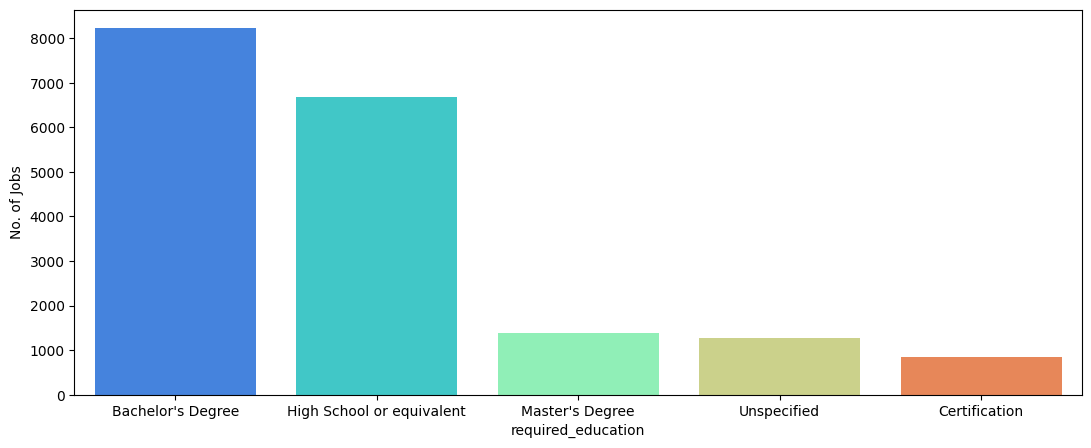

In [ ]:
plt.figure(figsize=(13,5))
country = df['required_education'].value_counts().nlargest(5).index.tolist()
ax=sns.countplot(data=df, x='required_education', order=country, palette='rainbow')
ax.set_ylabel('No. of Jobs')

# # EDA Insights

We have 17880 rows and 18 columns.

Number of columns with object dtype: 13

Number of columns with int64 dtype: 5

Salary_range has the maximum missing values.

Not fraud jobs: 17014
Fraud jobs: 866

4.84% of total jobs are fraudulent.

Maximum fraud jobs are from Full-time Employment Type.

Maximum fraud jobs are from Not Specified Required Experience.

#After removing outliners and missing values.
Full-time jobs are posted more comparatively to other type of employment.

There are more jobs available that requires Mid-senior level Experience.

There are maximum number of jobs are posted in IT field and minimum jobs are posted related to Distribution.
#After balancing the dataset and extracting countries.
US country has maximum job postings.

Full-time jobs are posted mostly.

Mid-Senior level is required experience in most of the job.

Bachelor's Degreee is required education in most of the job.

In [ ]:
df = pd.read_csv('/content/sample_data/fake_job_postings.csv',encoding='ISO-8859-1')

In [ ]:
#text_df now contains only these specified columns.
text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]

#Filling Missing Values
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI ï¿½ï¿½ï¿½ Environmental Syst...,EDUCATION:ï¿½ï¿½Bachelorï¿½ï¿½ï¿½s or Masterï¿...,Our culture is anything but corporateï¿½ï¿½ï¿½...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [ ]:
#Selecting Specific Columns
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]

#Filling Missing Values
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#Dropping Columns
df.drop(['salary_range','job_id'], axis = 1, inplace = True)

In [ ]:
#Filling Missing Values
df.fillna(" ",inplace = True)

In [ ]:
#Creating a Combined Text Column
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']

In [ ]:
#Dropping Original Columns
df.drop(['title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function'], axis = 1, inplace = True)

In [ ]:
#Creating a Text Length Feature
df['text_length'] = df.text.apply(len)
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text,text_length
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We...",2710
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ...",6246
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA...",2685
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash...",5566
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS...",4126


In [ ]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    #Replaces all characters in the text that are not letters (A–Z or a–z) with a space (" "). Removes punctuation, numbers, and special characters.
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower() # text to lowercase
    text = text.split() # Splits the text into a list of individual words (tokens).
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    # Joins the cleaned and lemmatized words back into a single string, with words separated by spaces.
    return ' '.join(text)

In [ ]:
# Applying the Function to the text Column
df['text'] = df['text'].apply(text_cleaning)

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text,text_length
0,0,1,0,0,marketing intern u ny new york marketing food ...,2710
1,0,1,0,0,customer service cloud video production nz auc...,6246
2,0,1,0,0,commissioning machinery assistant cma u ia wev...,2685
3,0,1,0,0,account executive washington dc u dc washingto...,5566
4,0,1,1,0,bill review manager u fl fort worth spotsource...,4126


# # Feature Extraction Insights
Combining columns into a single text feature allows the model to capture more holistic information, improving its ability to detect fraudulent postings.

Removing stopwords eliminates common words (e.g., "the", "is") that do not contribute to distinguishing between fraudulent and legitimate postings.

Adding text_length as a numerical feature gives the model additional context that complements the text-based features.

The vocabulary size from CountVectorizer represents the distinct terms in the training data, which the model uses as features.

Focused on only the necessary columns for training and discarded irrelevant columns (job_id, salary_range, etc.).


In [ ]:
#Extracting Features and Target
X = df.text
y = df.fraudulent

In [ ]:
#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12516,), (5364,), (12516,), (5364,))

In [ ]:
cv = CountVectorizer()
#Scans through all documents in x_train and identifies unique words, assigning each a unique integer index.
cv.fit(X_train)
len(cv.vocabulary_)

81534

In [ ]:
# Transform Training Data
X_train = cv.transform(X_train)

In [ ]:
# Transform Testing Data
X_test = cv.transform(X_test)

#Logistic Regression

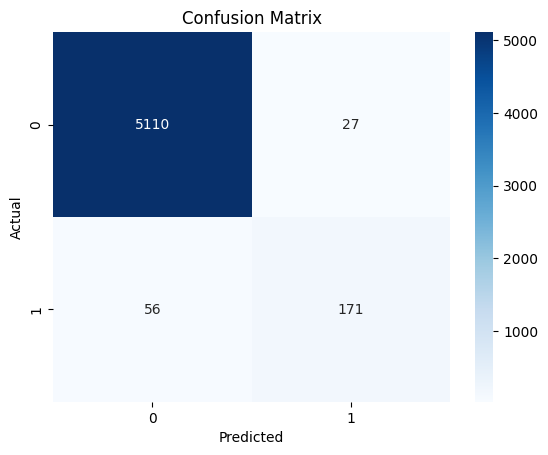

Cross-validation scores: [0.9784345  0.97762685 0.98322014 0.98282062 0.98481822]
Average cross-validation score: 0.9813840643623818
Test set accuracy: 0.9845264727815063
Test set precision: 0.8636363636363636
Test set recall: 0.7533039647577092
Test set F1 score: 0.8047058823529412


In [ ]:
# Initialize the Logistic Regression
model = LogisticRegression(max_iter=500)

# Perform 5-fold cross-validation on the training set to evaluate model performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Train the Logistic Regression model using the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred3 = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred3) # Overall correctness of the model
precision = precision_score(y_test, y_pred3) # Proportion of correctly identified positive cases
recall = recall_score(y_test, y_pred3) # Proportion of actual positives correctly identified
f1 = f1_score(y_test, y_pred3) # Balance between precision and recall

# Generate a confusion matrix to analyze prediction performance
cm = confusion_matrix(y_test, y_pred3)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print test set performance metrics
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)

#Logistic Regression Insights:

##Cross-Validation Scores:
These results indicate that the model performs consistently well across different subsets of the data, with a strong accuracy level overall.
This suggests that, on average, the logistic regression model is performing very well, achieving an accuracy of about 98.1%.

##Test Set Accuracy:
The model achieves ~98.45% accuracy, correctly predicting the majority of both fraudulent and legitimate job postings.
This is an excellent performance metric, suggesting that the model generalizes well to unseen data.

##Precision
The proportion of correctly predicted positive results among all positive predictions. This is relatively good but could be improved.

##Recall
The proportion of actual positives that were correctly predicted. Recall is lower compared to precision, indicating some instances of false negatives.

##F1 Score
This is the harmonic mean of precision and recall. It provides a balance between precision and recall. An F1 score of 80.47% shows a reasonable balance, though there may be some room for improvement, especially if false negatives need to be minimized.




#SVC

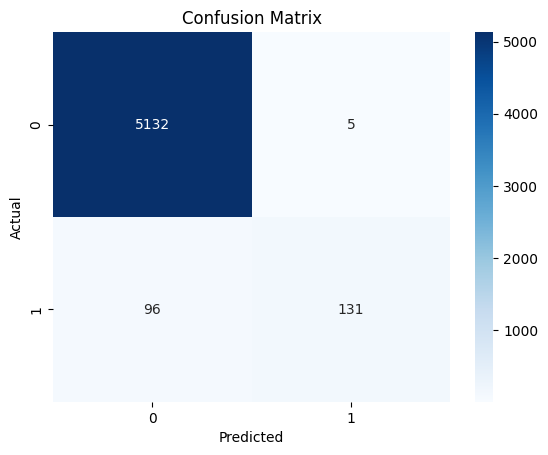

Cross-validation scores: [0.97244409 0.97403116 0.97522972 0.96923692 0.97363164]
Average cross-validation score: 0.9729147068246539
Test set accuracy: 0.9811707680835198
Test set precision: 0.9632352941176471
Test set recall: 0.5770925110132159
Test set F1 score: 0.721763085399449


In [ ]:
# Initialize the Support Vector Classifier
svc = SVC()

# Perform 5-fold cross-validation on the training set to evaluate model performance
cv_scores = cross_val_score(svc, X_train, y_train, cv=5)

# Train the SVC model using the training data
svc.fit(X_train, y_train)

# Make predictions on the test data
y_pred3 = svc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred3) # Overall correctness of the model
precision = precision_score(y_test, y_pred3) # Proportion of correctly identified positive cases
recall = recall_score(y_test, y_pred3) # Proportion of actual positives correctly identified
f1 = f1_score(y_test, y_pred3) # Balance between precision and recall

# Generate a confusion matrix to analyze prediction performance
cm = confusion_matrix(y_test, y_pred3)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print test set performance metrics
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)

#SVC Insights:

##Cross-Validation Scores:
This indicates that the model performs consistently well across different data splits, but it appears to be slightly less stable than the logistic regression model, where the scores were more consistently higher.

##Test Set Accuracy:
This is also a very strong performance, suggesting that the model generalizes well to unseen data.
Slightly lower accuracy than Logistic Regression (~98.45%), but still very high.

##Precision
This is quite high, indicating that when the model predicts a positive class, it is correct about 96% of the time. This suggests the model is very good at minimizing false positives.

##Recall
The recall is much lower compared to precision, meaning the model misses a significant portion of actual positive instances (false negatives). This could be an area of concern, depending on whether false negatives are critical in the specific application.

##F1 Score
The F1 score provides a balance between precision and recall. While it’s a bit lower than the logistic regression model (which had an F1 score of 80.47%), it indicates a decent trade-off between precision and recall, though there is potential for improvement.





#KNN

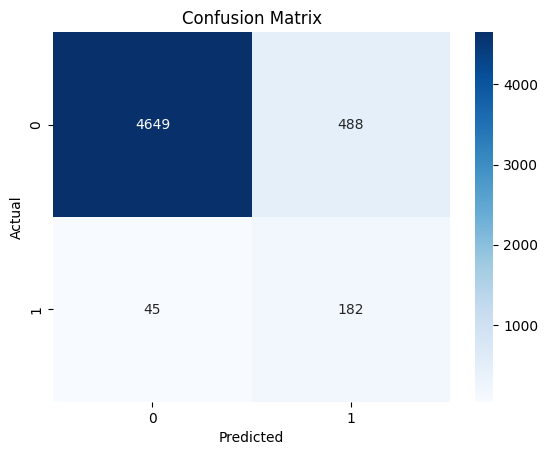

Cross-validation scores: [0.87819489 0.89692369 0.90011986 0.89852177 0.89972034]
Average cross-validation score: 0.8946961090780521
Test set accuracy: 0.9006338553318419
Test set precision: 0.2716417910447761
Test set recall: 0.801762114537445
Test set F1 score: 0.4057971014492754


In [ ]:
# Initialize the K-Nearest Neighbors classifierv
knn = KNeighborsClassifier()

# Perform 5-fold cross-validation on the training set to evaluate model performance
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

# Train the KNN model using the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred3 = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred3) # Overall correctness of the model
precision = precision_score(y_test, y_pred3) # Proportion of correctly identified positive cases
recall = recall_score(y_test, y_pred3) # Proportion of actual positives correctly identified
f1 = f1_score(y_test, y_pred3) # Balance between precision and recall

# Generate a confusion matrix to analyze prediction performance
cm = confusion_matrix(y_test, y_pred3)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print test set performance metrics
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)

#KNN Insights:

##Cross-Validation Scores:
The KNN model performs reasonably well, though the performance is somewhat lower than the Logistic Regression and SVC models, indicating some instability across different data splits.

##Test Set Accuracy:
The model correctly classifies ~90.06% of job postings in the test set.
While this accuracy is reasonable, it is significantly lower than Logistic Regression and SVC, indicating weaker performance overall.

##Precision
The precision is very low, indicating that when the KNN model predicts the positive class, it is correct only about 27% of the time. This suggests that the model is misclassifying a large number of positive instances as negative (false positives).

##Recall
The model successfully identifies 80.18% of actual fraudulent job postings.
Higher recall compared to SVC (57.71%) and Logistic Regression (75.33%) makes KNN better at detecting fraudulent postings.

##F1 Score
The F1 score is quite low, reflecting the trade-off between low precision and relatively high recall. The model's performance is imbalanced, favoring recall over precision, which might not be desirable depending on the application..


#Random Forest Classifier

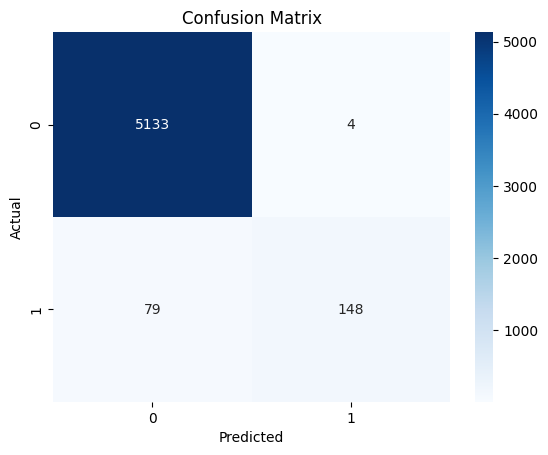

Cross-validation scores: [0.97763578 0.97642829 0.97802637 0.97682781 0.98162205]
Average cross-validation score: 0.9781080594660209
Test set accuracy: 0.9845264727815063
Test set precision: 0.9736842105263158
Test set recall: 0.6519823788546255
Test set F1 score: 0.7810026385224275


In [ ]:
# Initialize the Random Forest Classifier classifier
rfc = RandomForestClassifier()

# Train the RFC model using the training data
rfc.fit(X_train, y_train)

# Perform 5-fold cross-validation on the training set to evaluate model performance
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)

# Make predictions on the test data
y_pred3 = rfc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred3) # Overall correctness of the model
precision = precision_score(y_test, y_pred3) # Proportion of correctly identified positive cases
recall = recall_score(y_test, y_pred3) # Proportion of actual positives correctly identified
f1 = f1_score(y_test, y_pred3) # Balance between precision and recall

# Generate a confusion matrix to analyze prediction performance
cm = confusion_matrix(y_test, y_pred3)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print test set performance metrics
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())
print('Test set accuracy:', accuracy)
print('Test set precision:', precision)
print('Test set recall:', recall)
print('Test set F1 score:', f1)

#Random Forest Classifier Insights:

##Cross-Validation Scores:
The RFC model performs very consistently across different splits, with strong accuracy in each fold, suggesting that it generalizes well and is stable in terms of performance.

##Test Set Accuracy:
The model correctly classifies ~98.45% of job postings in the test set.
High accuracy places Random Forest on par with Logistic Regression (~98.45%) and slightly better than SVC (~98.12%).

##Precision
This is an excellent precision score, meaning that when the model predicts the positive class, it is correct about 97% of the time. The RFC model has a low false positive rate, which is highly desirable.

##Recall
Identifies 65.20% of actual fraudulent postings, which is lower than KNN (80.18%) and Logistic Regression (75.33%) but better than SVC (57.71%).

##F1 Score
The F1 score (~78.10%) reflects a balance between precision and recall. While the precision is high, the recall is lower, leading to a moderate F1 score. This suggests that the RFC model has a decent overall performance but may still benefit from further tuning to improve recall.



# # Hyperparameter Tuning

In [ ]:
import joblib
joblib.dump(cv, 'count_vectorizer.pkl')

In [ ]:
def search(model, tuned_parameters, score="f1"):
    """
    Perform hyperparameter tuning for a given model using GridSearchCV.

    Parameters:
    - model: The machine learning model to tune.
    - tuned_parameters: Dictionary of parameters to search over.
    - score: Metric to optimize during tuning (default: "f1").
    """
    # Record the start time for tracking how long the process takes
    start_time = time.time()

    print("# Tuning hyper-parameters for %s" % score)
    print()

    # Initialize GridSearchCV with the provided model, parameter grid, and scoring metric
    clf = GridSearchCV(
        model, tuned_parameters, n_jobs=-1, scoring='%s' % score
    )

    # Fit the model on the training data to find the best parameters
    clf.fit(X_train, y_train)

    # Save the tuned model to a file for later use
    joblib.dump(clf, 'KNeighborsClassifier_model.pkl')

    # Display the best parameters found during tuning
    print("Best parameters set found on development set: ", clf.best_params_)
    print()

    print("Detailed classification report:")
    print()

    # Generate predictions on the test set using the best model
    y_true, y_pred = y_test, clf.predict(X_test)

    # Print the classification report for the predictions
    print(classification_report(y_true, y_pred))
    print()

    # Calculate and print the time taken for the tuning process
    tim = time.time() - start_time
    print("---time taken %s seconds ---" % (tim))

In [ ]:
def fitModel(model, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test):
    """
    Train a model, evaluate its performance, and generate key metrics.

    Parameters:
    - model: The machine learning model to train and evaluate.
    - x_train, y_train: Training dataset (default: X_train, y_train).
    - x_test, y_test: Testing dataset (default: X_test, y_test).
    """
    # Assign the provided model to a local variable
    lr = model

    # Train the model on the training dataset
    lr.fit(x_train, y_train)

    # Generate predictions on the test dataset
    preds = lr.predict(x_test)

    # Generate a confusion matrix for the test predictions
    cm_1 = confusion_matrix(y_test, preds)

    # Convert the confusion matrix to a DataFrame for better visualization
    cm_1 = pd.DataFrame(cm_1, index=[0, 1], columns=[0, 1])

    # Plot the confusion matrix
    plt.title('Confusion Matrix')  # Add a title to the plot
    cm_1.index.name = 'Actual'    # Label the rows as "Actual"
    cm_1.columns.name = 'Predicted'  # Label the columns as "Predicted"
    sns.heatmap(cm_1, cmap="Blues", annot=True, fmt='')  # Create a heatmap visualization

#Hypertuning Logistic Regression

In [ ]:
# Defining hyperparameters for Logistic Regression and performing hyperparameter tuning using GridSearchCV
parameters = [
                    {'penalty':['l2'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                     'C': [0.1,1, 10, 100, 1000]},
                   {'penalty':['none'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                     'C': [0.1,1, 10, 100, 1000]}]

# Perform hyperparameter tuning for Logistic Regression using GridSearchCV
search(LogisticRegression(),parameters)

# Tuning hyper-parameters for f1

Best parameters set found on development set:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5137
           1       0.84      0.76      0.80       227

    accuracy                           0.98      5364
   macro avg       0.91      0.88      0.90      5364
weighted avg       0.98      0.98      0.98      5364


---time taken 113.3732750415802 seconds ---


# Hypertuned Logictic Regression Insights:
The optimal hyperparameters identified through GridSearchCV were:

C: 10

Penalty: 'l2'

Solver: 'liblinear'

These hyperparameters resulted in the best performance for the Logistic Regression model based on the f1 score.

Accuracy: 98% - The model performed well, correctly predicting the majority of the instances (5364 total samples), with a high overall accuracy.

Precision for class 0 (non-fraudulent jobs): 99% - The model is highly accurate at predicting non-fraudulent jobs, with very few false positives.

Precision for class 1 (fraudulent jobs): 84% - While the precision is still good, there are a few more false positives in predicting fraudulent jobs.

Recall for class 0: 99% - The model successfully identifies most non-fraudulent jobs, with very few false negatives.

Recall for class 1: 76% - The model captures about 76% of fraudulent jobs but misses some, indicating room for improvement in identifying fraudulent jobs.

F1-Score for class 0: 0.99 - Extremely high performance for non-fraudulent job prediction.

F1-Score for class 1: 0.80 - A decent performance for fraudulent job prediction, but there's room for improvement.

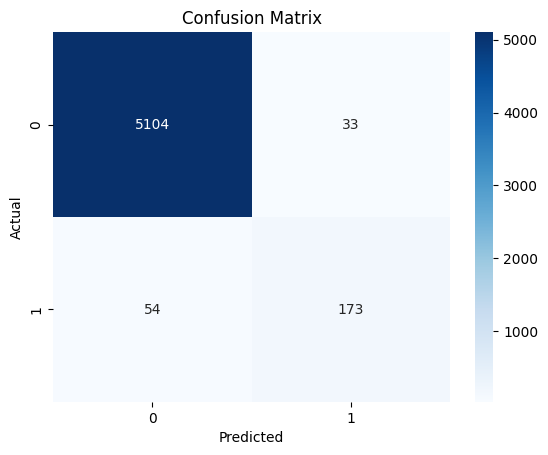

In [ ]:
# Fitting Logistic Regression model with optimal hyperparameters (C=10, solver='liblinear')
l = fitModel(LogisticRegression(C=10,solver = 'liblinear'))

#Hypertuning SVC

In [ ]:
# Defining hyperparameters for Support Vector Classifier (SVC) with different kernels and their corresponding hyperparameters
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                   {'kernel': ['poly'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

# Perform hyperparameter tuning for SVC using GridSearchCV
search(SVC(),parameters)

# Tuning hyper-parameters for f1

Best parameters set found on development set:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5137
           1       0.84      0.79      0.81       227

    accuracy                           0.98      5364
   macro avg       0.92      0.89      0.90      5364
weighted avg       0.98      0.98      0.98      5364


---time taken 3732.627832889557 seconds ---


# Hypertuned SVC Insights:
The optimal hyperparameters identified through GridSearchCV were:

C: 1000

Gamma: 0.001

Kernel: 'rbf' (Radial Basis Function)

Accuracy: 98% - The SVC model achieved a high accuracy, correctly classifying the majority of instances (5364 total samples).

Precision for class 0 (non-fraudulent jobs): 99% - The model is highly accurate at predicting non-fraudulent jobs, with very few false positives.

Precision for class 1 (fraudulent jobs): 84% - There are some false positives in predicting fraudulent jobs, though still a relatively strong performance.

Recall for class 0: 99% - The model successfully identifies most non-fraudulent jobs, with very few false negatives.

Recall for class 1: 79% - The model captures about 79% of fraudulent jobs, showing a good performance in detecting fraud, though still missing a small portion.

F1-Score for class 0: 0.99 - Excellent performance in predicting non-fraudulent jobs, with a near-perfect balance of precision and recall.

F1-Score for class 1: 0.81 - A good performance in predicting fraudulent jobs, but there is room for improvement, especially in recall.



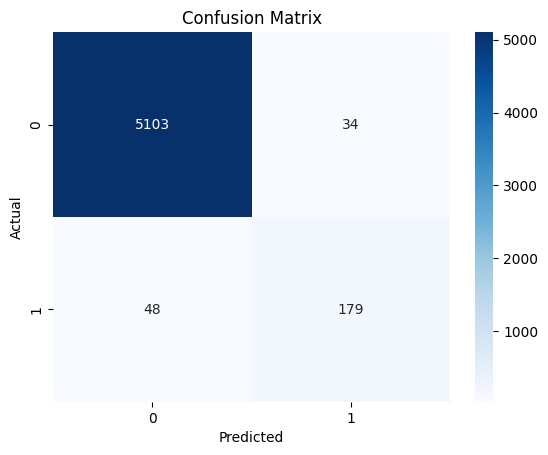

In [ ]:
# Fitting the SVC model with selected hyperparameters (C=1000, gamma=0.001, kernel='rbf')
l = fitModel(SVC(C=1000,gamma=0.001,kernel = 'rbf'))

#Hypertuning KNN



In [ ]:
# Defining hyperparameters for K-Nearest Neighbors (KNN) with various k values, weight types, and distance metrics
parameters = {"n_neighbors":[3,5,10,15,20,30,50,80],"weights":["uniform","distance"],
                   "metric":["euclidean","manhattan"]}

# Perform hyperparameter tuning for KNN using GridSearchCV
search(KNeighborsClassifier(),parameters)

# Tuning hyper-parameters for f1

Best parameters set found on development set:  {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5137
           1       0.65      0.71      0.68       227

    accuracy                           0.97      5364
   macro avg       0.82      0.85      0.83      5364
weighted avg       0.97      0.97      0.97      5364


---time taken 4129.576049566269 seconds ---


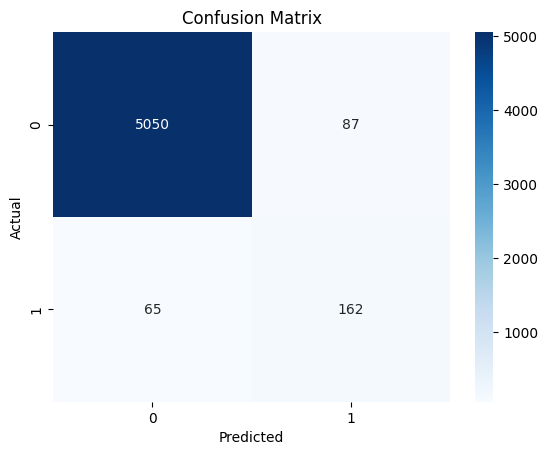

In [ ]:
# Fitting KNN model with selected hyperparameters (metric='manhattan', weights='distance', n_neighbors=20)
l = fitModel(KNeighborsClassifier(metric = 'manhattan',weights='distance',n_neighbors = 20))

# Hypertuned KNN Insights:
The optimal hyperparameters found through GridSearchCV were:

Metric: 'manhattan' (This distance metric calculates the sum of absolute differences between points.)

Number of Neighbors: 20 (The model considers the 20 closest neighbors to make predictions.)

Weights: 'distance' (This means that closer neighbors have more influence on the classification.)

Accuracy: 97% - The KNN model correctly classified a majority of the instances (5364 total samples), although slightly lower than the Logistic Regression and SVC models.

Precision for class 0 (non-fraudulent jobs): 99% - The model is highly accurate in predicting non-fraudulent jobs, with very few false positives.

Precision for class 1 (fraudulent jobs): 65% - There is a higher number of false positives for fraudulent jobs, meaning the model tends to predict non-fraudulent jobs as fraudulent more often.

Recall for class 0: 98% - The model successfully identifies most non-fraudulent jobs, with a small number of false negatives.

Recall for class 1: 71% - The model is able to identify 71% of fraudulent jobs, showing a decent performance in detecting fraud.

F1-Score for class 0: 0.99 - The model has an excellent balance of precision and recall for non-fraudulent jobs.

F1-Score for class 1: 0.68 - Although the model shows reasonable recall for fraudulent jobs, the precision is lower, leading to a lower f1-score for this class.

